# GMMM Submission AI Hackathon Lockeed Martin

 - Author: Cesar Ruiz, Edyan Cruz, Angel Morales, Yahid Diaz
 - Date: September 7 , 2025

## Download dependencies:

In [1]:
!pip install -r requirements.txt

## Download Dataset

In [2]:
import kagglehub
path = kagglehub.dataset_download("olebro/nasa-geographical-objects-multilabel-dataset")

/home/cesar/kickoff_material/hackathon/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path

'/home/cesar/.cache/kagglehub/datasets/olebro/nasa-geographical-objects-multilabel-dataset/versions/1'

### Importing Libraries

In [4]:
import argparse
import ast
import datetime
import json
import os
import time
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score
from transformers import AutoImageProcessor,AutoModelForImageClassification,get_cosine_schedule_with_warmup
import ast, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns

## Configs

In [5]:
torch.manual_seed(0)
np.random.seed(0)
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_csv = "data/train.csv"
val_csv = "data/val.csv"
images_path = os.path.join(path, "images")
image_size = 224
model_id = "facebook/dinov2-base"
batch_size = 32
workers = 15
num_classes = 10
weight_decay = 0.05
warmup_ratio = 0.05
epochs = 30
lr = 4e-5
log_dir = "./log_dir"
output_dir = "output"
eval_only = False


## Dataset Definition

In [6]:
class KaggleGeographicalDataset(Dataset):
    """
    Reads `FileName` and `Label Vector`.
    Builds a case-insensitive map of files and tolerates extension differences.
    Returns (pixel_values, label_tensor).
    """
    def __init__(self, csv_file, images_dir, processor_name, image_size=224, augment=False):
        self.df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.image_size = image_size
        self.augment = augment
        self.augment_prob = 0.05

        self.processor = AutoImageProcessor.from_pretrained(
            processor_name,
            do_resize=True,
            size={"height": image_size, "width": image_size},
            do_center_crop=False,
        )
    def __len__(self):
        return len(self.df)

    def _hflip(self, img):
        return np.ascontiguousarray(img[:, ::-1, :])

    def _vflip(self, img):
        return np.ascontiguousarray(img[::-1, :, :])

    def _rot90k(self, img, k):
        if k % 4 == 0:
            return img
        return np.ascontiguousarray(np.rot90(img, k).copy())

    def _small_rotate(self, img, max_deg=360):
        ang = (np.random.rand() * 2 - 1) * max_deg
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), ang, 1.0)
        return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    def _random_resized_crop(self, img, scale=(0.6, 1.0), ratio=(0.75, 1.33)):
        h, w = img.shape[:2]
        area = h * w
        for _ in range(10):
            target_area = np.random.uniform(*scale) * area
            log_ratio = (np.log(ratio[0]), np.log(ratio[1]))
            aspect = np.exp(np.random.uniform(*log_ratio))
            new_w = int(round(np.sqrt(target_area * aspect)))
            new_h = int(round(np.sqrt(target_area / aspect)))
            if 0 < new_w <= w and 0 < new_h <= h:
                x1 = np.random.randint(0, w - new_w + 1)
                y1 = np.random.randint(0, h - new_h + 1)
                crop = img[y1:y1+new_h, x1:x1+new_w]
                return cv2.resize(crop, (w, h), interpolation=cv2.INTER_LINEAR)
        min_side = min(h, w)
        y1 = (h - min_side) // 2; x1 = (w - min_side) // 2
        crop = img[y1:y1+min_side, x1:x1+min_side]
        return cv2.resize(crop, (w, h), interpolation=cv2.INTER_LINEAR)

    def _color_jitter(self, img, br=0.2, ct=0.2, sat=0.2):
        img_f = img.astype(np.float32)
        if br > 0:
            factor = 1.0 + np.random.uniform(-br, br)
            img_f = img_f * factor
        if ct > 0:
            mean = img_f.mean(axis=(0,1), keepdims=True)
            factor = 1.0 + np.random.uniform(-ct, ct)
            img_f = (img_f - mean) * factor + mean
        img_f = np.clip(img_f, 0, 255)

        if sat > 0:
            hsv = cv2.cvtColor(img_f.astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
            s_factor = 1.0 + np.random.uniform(-sat, sat)
            hsv[...,1] = np.clip(hsv[...,1] * s_factor, 0, 255)
            img_f = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32)

        return np.clip(img_f, 0, 255).astype(np.uint8)

    def _gaussian_blur(self, img):
        k = np.random.choice([3, 5])
        return cv2.GaussianBlur(img, (k, k), 0)
  

    def _gaussian_noise(self, img, sigma=5.0):
        noise = np.random.randn(*img.shape).astype(np.float32) * sigma
        out = img.astype(np.float32) + noise
        return np.clip(out, 0, 255).astype(np.uint8)
  

    def _random_erasing(self, img, area_ratio=(0.02, 0.12), min_aspect=0.3):

        h, w = img.shape[:2]
        area = h * w
        for _ in range(10):
            target = np.random.uniform(*area_ratio) * area
            aspect = np.random.uniform(min_aspect, 1/min_aspect)
            er_w = int(round(np.sqrt(target * aspect)))
            er_h = int(round(np.sqrt(target / aspect)))
            if er_w < w and er_h < h:
                x1 = np.random.randint(0, w - er_w + 1)
                y1 = np.random.randint(0, h - er_h + 1)
                fill = np.random.randint(0, 256, (er_h, er_w, 3), dtype=np.uint8)
                img[y1:y1+er_h, x1:x1+er_w] = fill
                return img
        return img

    def _maybe_augment(self, img_rgb):
        if not self.augment:
            return img_rgb

        # Order of ops: geo -> crop -> color -> blur/noise -> erase
        if np.random.rand() < self.augment_prob:
            img_rgb = self._hflip(img_rgb)
        if np.random.rand() < self.augment_prob:
            img_rgb = self._vflip(img_rgb)
        if np.random.rand() < self.augment_prob:
            img_rgb = self._rot90k(img_rgb, np.random.randint(0, 4))
        if np.random.rand() < self.augment_prob:
            img_rgb = self._small_rotate(img_rgb, max_deg=90)
        if np.random.rand() < self.augment_prob:
            img_rgb = self._random_resized_crop(img_rgb, scale=(0.6, 1.0), ratio=(0.75, 1.33))
        if np.random.rand() < self.augment_prob:
            img_rgb = self._color_jitter(img_rgb, br=0.15, ct=0.15, sat=0.15)
        if np.random.rand() < self.augment_prob:
            img_rgb = self._gaussian_blur(img_rgb)
        if np.random.rand() < self.augment_prob:
            img_rgb = self._gaussian_noise(img_rgb, sigma=5.0)
        if np.random.rand() < self.augment_prob:
            img_rgb = self._random_erasing(img_rgb, area_ratio=(0.02, 0.12), min_aspect=0.3)

        return img_rgb


    def __getitem__(self, idx):
        img_path = os.path.join(images_path,self.df["FileName"][idx])
        image = cv2.imread(img_path)  # BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self._maybe_augment(image)
        label_vec = ast.literal_eval(self.df["Label Vector"][idx])
        label = torch.tensor(label_vec, dtype=torch.float32)
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)
        return pixel_values, label

## Balance Helper Function

In [7]:
def compute_pos_weight_from_csv(train_csv_path: str, device: torch.device, eps: float = 1e-6):
    df = pd.read_csv(train_csv_path)
    Y = np.stack([np.array(ast.literal_eval(s), dtype=np.float32) for s in df["Label Vector"]])  # (N, C)
    pos = Y.sum(axis=0)                     # positives per class
    neg = Y.shape[0] - pos                  # negatives per class
    pw = neg / (pos + eps)                  # ratio -> larger weight for rare classes
    # (Optional) clamp huge values if you have classes with 0 positives
    pw = np.clip(pw, 1.0, 100.0)
    return torch.tensor(pw, dtype=torch.float32, device=device)

## F1 Calculator

In [8]:

@torch.no_grad()
def evaluate(model, dataloader, device, criterion):
    model.eval()

    total_loss = 0.0
    all_pred, all_true = [], []

    for pixel_values, labels in dataloader:
        pixel_values = pixel_values.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(pixel_values=pixel_values).logits
        loss = criterion(logits, labels)
        total_loss += loss.item() * pixel_values.size(0)

        preds = (logits.sigmoid() > 0.5).int().cpu().numpy()
        all_pred.append(preds)
        all_true.append(labels.int().cpu().numpy())

    all_pred = np.vstack(all_pred) if all_pred else np.zeros((0, 0))
    all_true = np.vstack(all_true) if all_true else np.zeros((0, 0))

    f1_micro = f1_score(all_true, all_pred, average="micro", zero_division=0) if len(all_true) else 0.0
    f1_macro = f1_score(all_true, all_pred, average="macro", zero_division=0) if len(all_true) else 0.0
    avg_loss = total_loss / max(len(dataloader.dataset), 1)

    return {"loss": avg_loss, "f1_micro": f1_micro, "f1_macro": f1_macro, "logits": logits}

## Training Helper

In [9]:
def train_one_epoch(model, dataloader, optimizer, scheduler, device, scaler, criterion):
    model.train()
    seen = 0
    running = 0.0
    labeles =[]
    for pixel_values, labels in dataloader:
        pixel_values = pixel_values.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        labeles.append(labels)

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=torch.cuda.is_available()):
            logits = model(pixel_values=pixel_values).logits
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running += loss.item() * pixel_values.size(0)
        seen += pixel_values.size(0)

    return labeles

## Main Training Loop

In [11]:
train_ds = KaggleGeographicalDataset(
        train_csv, images_path, processor_name=model_id,
        image_size=image_size, augment=True,
    )
val_ds = KaggleGeographicalDataset(
        val_csv, images_path, processor_name=model_id,
        image_size=image_size, augment=False
    )

train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True, drop_last=True
    )
val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True
    )


model = AutoModelForImageClassification.from_pretrained(
        model_id,
        num_labels=num_classes,
        problem_type="multi_label_classification",
        ignore_mismatched_sizes=True,
    ).to(device)


no_decay = ["bias", "LayerNorm.weight"]
param_groups = [
        {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay},
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0},
    ]
optimizer = torch.optim.AdamW(param_groups, lr=lr)
total_steps = max(1, len(train_loader)) * epochs
warmup_steps = int(total_steps * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
    )
pos_weight = compute_pos_weight_from_csv(train_csv, device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())
# Logging mkdir intialization
os.makedirs(output_dir, exist_ok=True)

# Train
best_f1 = 0.0
history_f1_val = []
history_f1_train = []
history_loss_val = []
history_loss_train = []
       # Store batch results
actual_labels = []
predicted_labels = []
t0 = time.time()
print(f"Start training for {epochs} epochs")
for epoch in range(epochs):
    actual_label = train_one_epoch(model, train_loader, optimizer, scheduler, device, scaler, criterion)
    val_stats  = evaluate(model, val_loader, device, criterion)
    train_stats = evaluate(model, train_loader, device, criterion)
    print(f"Epochs: {epoch}\n")
    print(f"[Eval] loss={val_stats['loss']:.4f} | f1_micro={val_stats['f1_micro']:.4f} | f1_macro={val_stats['f1_macro']:.4f}")
    print(f"[Train] loss={train_stats['loss']:.4f} | f1_micro={train_stats['f1_micro']:.4f} | f1_macro={train_stats['f1_macro']:.4f}\n")
    history_f1_val.append(val_stats['f1_micro'])
    history_f1_train.append(train_stats['f1_micro'])
    history_loss_val.append(val_stats["loss"])
    history_loss_train.append(train_stats["loss"])

    
    actual_labels.append(actual_label)
    predicted_labels.append(val_stats["logits"])

    if val_stats["f1_micro"] > best_f1:
        best_f1 = val_stats["f1_micro"]
        best_path = os.path.join(output_dir, f"best_f1_{best_f1:.4f}.pt")
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "pos_weight": pos_weight.detach().cpu().tolist(), 
        }, best_path)

        print(f"New best F1_micro={best_f1:.4f} -> {best_path}")
total = str(datetime.timedelta(seconds=int(time.time() - t0)))
print(f"\nDone. Best F1_micro={best_f1:.4f}. Total time: {total}")

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 5384.22it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1586.35it/s]
Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training for 30 epochs


/home/cesar/kickoff_material/hackathon/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epochs: 0

[Eval] loss=0.4605 | f1_micro=0.7812 | f1_macro=0.6759
[Train] loss=0.4174 | f1_micro=0.7841 | f1_macro=0.7122

New best F1_micro=0.7812 -> output/best_f1_0.7812.pt
Epochs: 1

[Eval] loss=0.3370 | f1_micro=0.8064 | f1_macro=0.7162
[Train] loss=0.2364 | f1_micro=0.8354 | f1_macro=0.7464

New best F1_micro=0.8064 -> output/best_f1_0.8064.pt
Epochs: 2

[Eval] loss=0.2701 | f1_micro=0.8792 | f1_macro=0.8154
[Train] loss=0.1153 | f1_micro=0.9083 | f1_macro=0.8979

New best F1_micro=0.8792 -> output/best_f1_0.8792.pt


KeyboardInterrupt: 

In [12]:
model


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2Laye

## Data Visualization

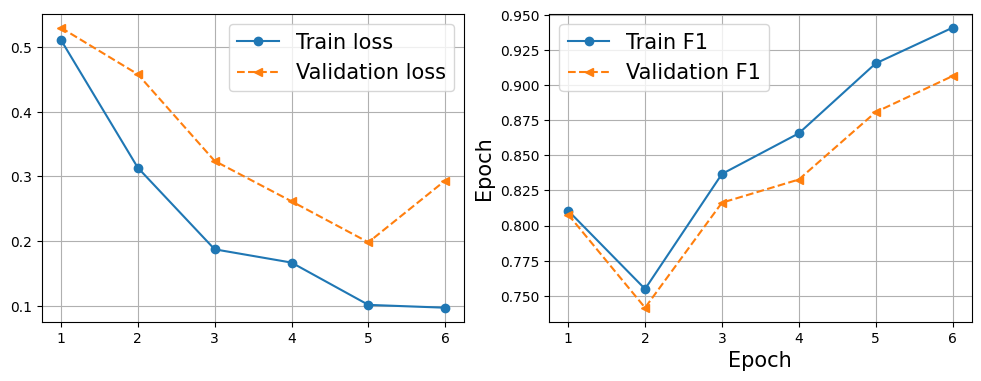

In [ ]:
x_axis = np.arange(epoch) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, history_loss_train, '-o', label = 'Train loss')
ax.plot(x_axis, history_loss_val, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax.grid(True)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, history_f1_train, '-o', label='Train F1')
ax.plot(x_axis, history_f1_val, '--<', label='Validation F1')        
ax.legend(fontsize=15)
ax.grid(True)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Epoch', size=15)
plt.show()

## Confusion Matrix

In [ ]:
from typing import List
def create_multilabel_confusion_matrix(y_true_arrays: List[list], y_pred_arrays: list, test_data_raw: pd.DataFrame):
    valid_combinations = []
    valid_label_names = {}
    
    # unique label vectors from test data
    for _, row in test_data_raw.drop_duplicates(subset=['Label Vector']).iterrows():
        label_vector = np.array(row['Label Vector'].strip('[]').split(', '), dtype=int)
        if isinstance(label_vector, np.ndarray):
            vector_tuple = tuple(label_vector.flatten())
        else:
            for arr in label_vector:
                if isinstance(arr, np.ndarray):
                    vector_tuple = tuple(arr.flatten())
                    break
                    
        valid_combinations.append(vector_tuple)
        valid_label_names[vector_tuple] = row['Label String']
    
    # add "Other" category
    other_idx = len(valid_combinations)
    
    # convert true and predicted arrays to tuples
    y_true_tuples = []
    y_pred_tuples = []
    
    for array in y_true_arrays:
        for row in array:
            y_true_tuples.append(tuple(row))
            
    for array in y_pred_arrays:
        for row in array:
            y_pred_tuples.append(tuple(row))
    
    # Map each tuple to the index of its class or to "Other"
    def get_class_index(tup):
        if tup in valid_combinations:
            return valid_combinations.index(tup)
        else:
            return other_idx
    
    # convert tuples to class indices
    y_true_indices = [get_class_index(t) for t in y_true_tuples]
    y_pred_indices = [get_class_index(t) for t in y_pred_tuples]
    
    # create labels for the confusion matrix
    labels = [valid_label_names[combo] for combo in valid_combinations] + ["Other"]
    
    # create the confusion matrix
    cm = confusion_matrix(y_true_indices, y_pred_indices, 
                          labels=range(len(valid_combinations) + 1))
    
    # create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    return cm, cm_df, labels

def plot_confusion_matrix(cm_df, labels, figsize=(15, 15)):
    # create the plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for Multilabel Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return plt.gcf()
val_df = pd.read_csv(val_csv)
cm, cm_df, labels = create_multilabel_confusion_matrix(
    actual_labels, predicted_labels,val_df )
fig = plot_confusion_matrix(cm_df, labels)
plt.show()

## Model Insights

### Attention Visualization

In [ ]:

n_params = sum(p.numel() for p in model.parameters())
print(f"Model params: {n_params/1e6:.2f}M")

NameError: name 'model' is not defined